# Reconstructing Images from Brain Signals

## Setting up and Importing

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import cv2
from skimage import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torchvision import datasets, transforms
import torch.optim as optim
import os
from scipy import stats


from tqdm import tqdm
import tensorflow as tf

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

np.random.seed(0)

Mounted at /content/gdrive


The following code imports datasets from Google Drive.

In [2]:
img_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/train_img_m1s2.npy')
rsp_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/trainRsp_m1s2.npy')

val_img_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/val_img_m1s2.npy')
val_rsp_dataset = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/Valrsp_alltrials_afterclean.npy', allow_pickle=True).item()['m1s2']

img_dataset = np.squeeze(img_dataset)
val_img_dataset = np.squeeze(val_img_dataset)
val_rsp_dataset = val_rsp_dataset.transpose(1, 2, 0)
print(img_dataset.shape)
print(val_img_dataset.shape)

(50700, 100, 100)
(1000, 100, 100)


## Creating and Centering Image Datasets


centerOnly returns a dataset comprised only of image centers. The width & height of the image centers is defined by img_new_size.

displaySquare simply adds a white highlight square to help visualize the size of the center we are using.

In [3]:
def centerOnly(img_dataset, img_size, img_new_size):
  sidebands = int((img_size - img_new_size) / 2)
  return img_dataset[:, sidebands : img_size - sidebands, sidebands : img_size - sidebands]

def displaySquare(first_img, img_size, img_new_size):
  img = copy.deepcopy(first_img)
  sidebands = int((img_size - img_new_size) / 2)
  for i in range(sidebands-1, img_size - sidebands + 1):
    for j in range(sidebands-1, img_size - sidebands + 1):
      if (i == sidebands-1 or i == img_size - sidebands or j == sidebands-1 or j == img_size - sidebands):
        img[i, j] = 1
  return img

## Create the 2d brain maps to be used as inputs

In [4]:
all_cell_mean_pos = np.load('/content/gdrive/MyDrive/Image Decoding/Datasets/all_cell_mean_pos.npy')

The following function returns a response as a 2d map of the given resolution (e.g. 35 for a 35 x 35 pixel map)

In [5]:
def fullResolution(response, resolution):
  fullResMap = np.zeros((resolution, resolution))
  for i, resp in enumerate(response):
    fullResMap[int(all_cell_mean_pos[i,0] * resolution/500), int(all_cell_mean_pos[i,1] * resolution/500)] = max(resp, fullResMap[int(all_cell_mean_pos[i,0] * resolution/500), int(all_cell_mean_pos[i,1] * resolution/500)])
  return fullResMap

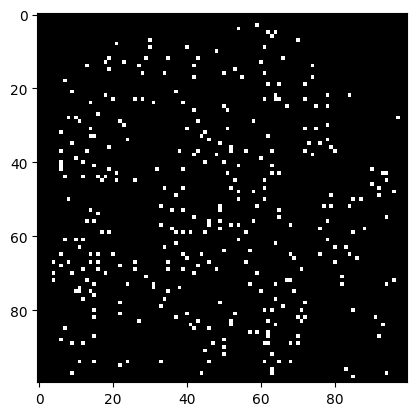

In [6]:
rsp = np.ones((330))
rsp_img_naive = rsp[:324].reshape((18, 18))
rsp_image_complex = fullResolution(rsp, 100)


rsp_img = tf.image.grayscale_to_rgb(tf.convert_to_tensor(rsp_image_complex[:, :, None]))
plt.imshow(rsp_img)
plt.show()

### Create and save the maps

In [8]:
fullResolution35 = np.zeros((len(rsp_dataset), 35, 35))

for i, rsp in enumerate(rsp_dataset):
  fullResolution35[i] = fullResolution(rsp, 35)

np.save("/content/gdrive/MyDrive/Image Decoding/50 x 50 material/train_2d_maps.npy", fullResolution35)

In [9]:
fullResolution35_Mean_Val = np.zeros((len(val_rsp_dataset), 35, 35))

for i, val_rsp in enumerate(val_rsp_dataset):
  fullResolution35_Mean_Val[i] = fullResolution(np.mean(val_rsp, axis = 0), 35)

np.save("/content/gdrive/MyDrive/Image Decoding/50 x 50 material/val_2d_maps.npy", fullResolution35_Mean_Val)

## Experiment Set-Up

The encodings of your training and validation set can be entered below, ase well as the name of the VAE that you will use for decoding (see VAE_Image_Encoding.ipynb)

In [10]:
IMG_SET = centerOnly(img_dataset, 100, 50)
IMG_VAL_SET = centerOnly(val_img_dataset, 100, 50)
IMG_SIZE = 50
IMG_ENCODINGS = np.load('/content/gdrive/MyDrive/Image Decoding/50 x 50 material/train_encodings_50.npy')
IMG_VAL_ENCODINGS = np.load('/content/gdrive/MyDrive/Image Decoding/50 x 50 material/val_encodings_50.npy')
VAE_FILENAME = '/content/gdrive/My Drive/Image Decoding/50 x 50 material/VAE_50.npy'
print(IMG_SET.shape)
print(IMG_VAL_SET.shape)
# CHANGE THE ENCODINGS
# encodings = np.load('/content/gdrive/My Drive/Spring Break Research/lat32_img_encodings.npy')
# val_encodings = np.load('/content/gdrive/My Drive/Spring Break Research/lat128_validation_img_encodings.npy')
# vae_filename = '/content/gdrive/My Drive/Spring Break Research/img_vae_v1_lat32.npy'

(50700, 50, 50)
(1000, 50, 50)


In [11]:
ED_rsp_size = 35
ED_dim_rsp = 330

rsp_35 = np.load("/content/gdrive/MyDrive/Image Decoding/50 x 50 material/train_2d_maps.npy")
rsp_330 = copy.deepcopy(rsp_dataset)
rsp_330 = np.reshape(np.append(rsp_330, np.zeros((len(rsp_330), ED_rsp_size * ED_rsp_size - ED_dim_rsp)), axis = 1), (len(rsp_330), 35, 35))
val_rsp_35 = np.load("/content/gdrive/MyDrive/Image Decoding/50 x 50 material/val_2d_maps.npy")
val_rsp_330 = np.mean(val_rsp_dataset, axis=1)
val_rsp_330 = np.reshape(np.append(val_rsp_330, np.zeros((len(val_rsp_330), 35 * 35 - len(val_rsp_330[0]))), axis = 1), (len(val_rsp_330), 35, 35))

## Create and Train a new Model

In [12]:
length = min([len(rsp_35), len(IMG_ENCODINGS)])
ED_batch_size = 16
ED_img_latent_dim = 32
ED_rsp_latent_dim = 32
ED_rsp_latent_dim_2 = 32
ED_rsp_1d_dim = 64
ED_epoch_num = 5
ED_img_size = IMG_SIZE
ED_train_size = 40000 // ED_batch_size * ED_batch_size
ED_total_size = length // ED_batch_size * ED_batch_size

img_lat_space_matrix = np.append(IMG_ENCODINGS, np.zeros((len(IMG_ENCODINGS), ED_rsp_size * ED_rsp_size - ED_img_latent_dim)), axis = 1)
img_lat_space_matrix = np.reshape(img_lat_space_matrix, (len(IMG_ENCODINGS), ED_rsp_size, ED_rsp_size))

ED_dataset = np.concatenate((rsp_35[:length, None, :, :], rsp_330[:length, None, :, :], img_lat_space_matrix[:length, None, :, :]), axis=1)

train_set = ED_dataset[:ED_train_size]
test_set = ED_dataset[ED_train_size:ED_total_size]

ED_train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=ED_batch_size, shuffle=True
)

ED_test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=ED_batch_size, shuffle=True
)

ED_shape_before_flattening = ED_batch_size, int(256), int(ED_img_size/2), int(ED_img_size/2)

In [13]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

class LatentSpaceBridge(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(LatentSpaceBridge, self).__init__()
        self.lin1 = torch.nn.Linear(input_dimension, 32)
        self.lin2 = torch.nn.Linear(32, 32)
        self.lin3 = torch.nn.Linear(32, output_dimension)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        return x

class DecodingMLP(nn.Module):
    def __init__(self, input_dimension, output_dimension):
      super(DecodingMLP, self).__init__()
      self.lin1 = torch.nn.Linear(input_dimension, 128)
      self.lin2 = torch.nn.Linear(128, 128)
      self.lin3 = torch.nn.Linear(128, 64)
      self.lin23 = torch.nn.Linear(128, output_dimension)
      self.lin4 = torch.nn.Linear(64, output_dimension)

    def forward(self, x):
      x = F.relu(self.lin1(x))
      #x = F.relu(self.lin2(x))
      x = F.relu(self.lin3(x))
      x = F.sigmoid(self.lin4(x))
      return x


class RSPEncoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(RSPEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.LazyLinear(embedding_dim)
        self.fc_log_var = nn.LazyLinear(embedding_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z, x

class Encoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.LazyLinear(embedding_dim)
        self.fc_log_var = nn.LazyLinear(embedding_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z, x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, full_size):

        super(Decoder, self).__init__()
        self.fc = nn.LazyLinear(full_size)
        self.shape_before_flattening = shape_before_flattening
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, padding=1, stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 2, padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, padding=1, stride=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 3, padding=0, stride=1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x, (self.shape_before_flattening))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        z_mean, z_log_var, z, _ = self.encoder(x)
        reconstruction = self.decoder(z)
        return [reconstruction, z]

class EnsembleDecoder(nn.Module):
    def __init__(self, encoder, bridge, mlp, encoder_dim, rsp_dim, mlp_dim, output_dim):
        super(EnsembleDecoder, self).__init__()
        self.encoder = encoder
        self.bridge = bridge
        self.mlp = mlp
        self.lin = torch.nn.Linear(encoder_dim + mlp_dim + rsp_dim, output_dim)

    def forward(self, x_2d, x_1d):
        z_mean, z_log_var, z, _ = self.encoder(x_2d)
        new_z = self.bridge(z)
        mlpres = self.mlp(x_1d)
        hidden = torch.cat((new_z, mlpres, x_1d), dim = -1)
        output = self.lin(hidden)
        return output

## Visual Representation of the Model

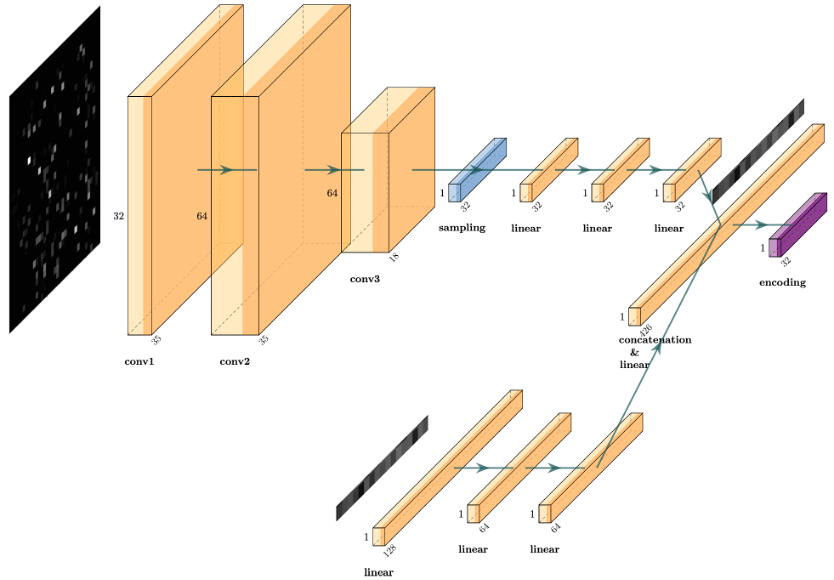

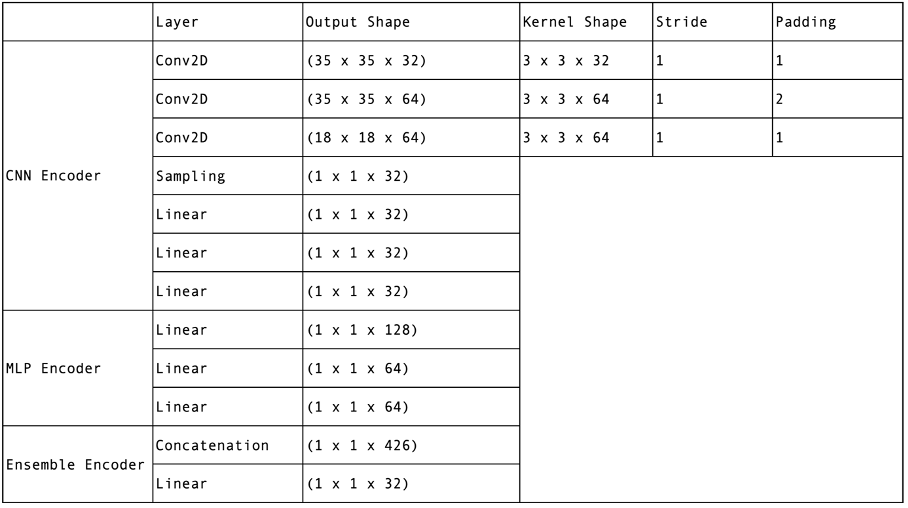

## Training the Model

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

encoder = RSPEncoder(ED_rsp_size, ED_rsp_latent_dim)
bridge = LatentSpaceBridge(ED_rsp_latent_dim, ED_rsp_latent_dim_2)
mlp = DecodingMLP(ED_dim_rsp, ED_rsp_1d_dim)
full_ensemble_decoder = EnsembleDecoder(encoder, bridge, mlp, ED_rsp_latent_dim_2, ED_dim_rsp, ED_rsp_1d_dim, ED_img_latent_dim).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(bridge.parameters()) + list(mlp.parameters()) + list(full_ensemble_decoder.parameters()))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, verbose=True)

best_val_loss = float("inf")
for epoch in range(ED_epoch_num):
    full_ensemble_decoder.train()
    running_loss = 0.0
    for batch_idx, data in tqdm(enumerate(ED_train_loader)):
        optimizer.zero_grad()
        data = data.float().to(device)
        origin_2D = data[:, 0]
        origin_1D = data[:, 1].flatten(start_dim=1)[:, :ED_dim_rsp]
        destination = data[:, 2].flatten(start_dim=1)[:, :ED_img_latent_dim]
        origin_2D = origin_2D[:, None, :, :]
        pred = full_ensemble_decoder(origin_2D, origin_1D).to(device)
        loss = nn.functional.mse_loss(pred, destination)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(ED_train_loader)

    running_val_loss = 0.0
    for batch_idx, data in enumerate(ED_test_loader):
        data = data.float().to(device)
        origin_2D = data[:, 0]
        origin_1D = data[:, 1].flatten(start_dim=1)[:, :ED_dim_rsp]
        destination = data[:, 2].flatten(start_dim=1)[:, :ED_img_latent_dim]
        origin_2D = origin_2D[:, None, :, :]
        pred = full_ensemble_decoder(origin_2D, origin_1D).to(device)
        loss = nn.functional.mse_loss(pred, destination)
        running_val_loss += loss.item()

    val_loss = running_val_loss / len(ED_test_loader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Device:  cuda


2500it [00:18, 133.08it/s]


Epoch 0 | Train Loss: 0.8791 | Val Loss: 0.9920


2500it [00:17, 143.73it/s]


Epoch 1 | Train Loss: 0.8430 | Val Loss: 0.9735


2500it [00:13, 182.25it/s]


Epoch 2 | Train Loss: 0.8260 | Val Loss: 0.9752


2500it [00:13, 182.23it/s]


Epoch 3 | Train Loss: 0.8079 | Val Loss: 0.9829


2500it [00:13, 180.52it/s]


Epoch 4 | Train Loss: 0.7881 | Val Loss: 0.9874


In [19]:
torch.save(full_ensemble_decoder.state_dict(), '/content/gdrive/My Drive/Image Decoding/50 x 50 material/Full_Decoder_50.npy')

## Reconstruction

In [17]:
length = min([len(val_rsp_35), len(IMG_VAL_ENCODINGS)])
ED_batch_size = 16
ED_img_latent_dim = 32
ED_rsp_latent_dim = 32
ED_rsp_latent_dim_2 = 32
ED_rsp_1d_dim = 64
ED_epoch_num = 5
ED_img_size = IMG_SIZE
ED_train_size = 900 // ED_batch_size * ED_batch_size
ED_total_size = length // ED_batch_size * ED_batch_size

img_lat_space_matrix = np.append(IMG_VAL_ENCODINGS, np.zeros((len(IMG_VAL_ENCODINGS), ED_rsp_size * ED_rsp_size - ED_img_latent_dim)), axis = 1)
img_lat_space_matrix = np.reshape(img_lat_space_matrix, (len(IMG_VAL_ENCODINGS), ED_rsp_size, ED_rsp_size))

VED_dataset = np.concatenate((val_rsp_35[:length, None, :, :], val_rsp_330[:length, None, :, :], img_lat_space_matrix[:length, None, :, :]), axis=1)

ED_shape_before_flattening = ED_batch_size, int(256), int(ED_img_size/2), int(ED_img_size/2)

number = 0
examples = torch.from_numpy(VED_dataset[number:number+ED_batch_size]).float().to(device)
origin_2D = examples[:, 0]
origin_2D = origin_2D[:, None, :, :]
origin_1D = examples[:, 1].flatten(start_dim=1)[:, :ED_dim_rsp]

encoder = Encoder(ED_img_size, ED_img_latent_dim)
decoder = Decoder(ED_img_latent_dim, ED_shape_before_flattening, 256*int(ED_img_size/2)*int(ED_img_size/2))
vae = VAE(encoder, decoder).to(device)
vae.load_state_dict(torch.load(VAE_FILENAME))

<All keys matched successfully>

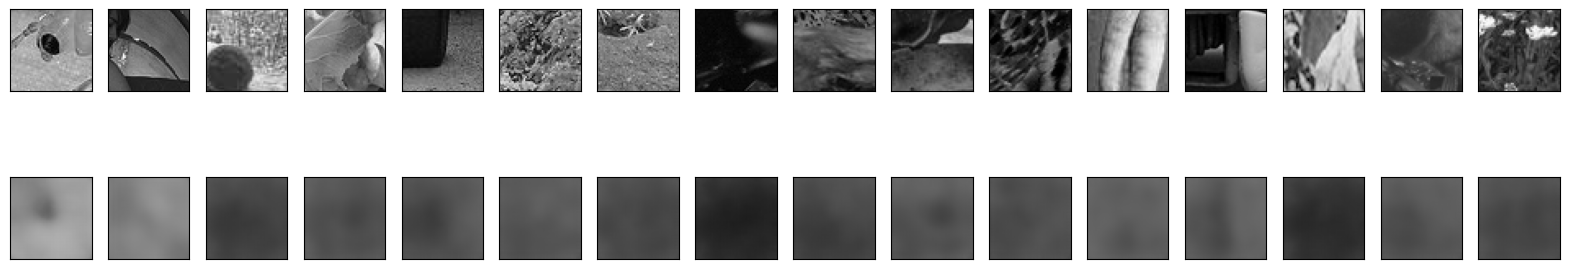

In [18]:
new_encodings = full_ensemble_decoder(origin_2D, origin_1D)
decoded_imgs = vae.decoder(new_encodings).cpu().detach().numpy().squeeze()[:, :, :, None]

plt.figure(figsize=(20, 4))
for i in range(ED_batch_size):
    ax = plt.subplot(2, ED_batch_size, i + 1)
    img = tf.image.grayscale_to_rgb(tf.convert_to_tensor(IMG_VAL_SET[number+i][:, :, None]))
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, ED_batch_size, i + 1 + ED_batch_size)

    plt.imshow(tf.image.grayscale_to_rgb(tf.convert_to_tensor(decoded_imgs[i])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## SSIM

In [20]:
batch_number = len(VED_dataset) // ED_batch_size
avg_ssim = 0
avg_corr = 0

for i in tqdm(range(batch_number)):
  examples = torch.from_numpy(VED_dataset[i * ED_batch_size : (i+1) * ED_batch_size]).float().to(device)
  origin_2D = examples[:, 0]
  origin_2D = origin_2D[:, None, :, :]
  origin_1D = examples[:, 1].flatten(start_dim=1)[:, :ED_dim_rsp]
  new_encodings = full_ensemble_decoder(origin_2D, origin_1D)
  decoded_imgs = vae.decoder(new_encodings).cpu().detach().numpy().squeeze()[:, :, :, None]

  for j in range(ED_batch_size):
    avg_ssim += metrics.structural_similarity(IMG_VAL_SET[i * ED_batch_size + j], decoded_imgs[j].squeeze(), full=True)[0]
    data = IMG_VAL_SET[i * ED_batch_size + j].flatten().squeeze()
    data[0] += 0.000001
    avg_corr += np.corrcoef(data, decoded_imgs[j].flatten().squeeze())

print("Average SSIM: ", avg_ssim/float(len(VED_dataset) // ED_batch_size * ED_batch_size))
print("Average corr: ", avg_corr[0, 1]/float(batch_number * ED_batch_size))

  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
100%|██████████| 62/62 [00:01<00:00, 48.39it/s]

Average SSIM:  0.38840636434726117
Average corr:  0.1617973700104584
